크롤링한 종목별(기업별) 재무제표 지표를 4개의 파생지수로 변환
- finance_table_ver1.csv 이용

In [1]:
import os
os.chdir('C:/Users/myhyu/OneDrive/Desktop/2024 미래에셋/InvestmentPropensity')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = 'C:/Windows/Fonts/malgun.ttf'  # Windows의 경우
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
import statsmodels.api as sm

# 데이터 불러오기
2362행  
* 결측치 모두 삭제된 데이터임
- 주요재무정보 : 기업코드
- 수익성 지수 : 영업이익률, 순이익률
- 가치 지수 : PER(배), PBR(배)
- 퀄리티 지수 : ROE, 부채비율
- 성장성 지수 : 매출성장률?

In [4]:
# 첫 행 제외하고 불러옴
df = pd.read_csv('finance_table_cleaned.csv',  encoding='utf-8')
df.head()

,기업코드,영업이익률,순이익률,매출액차,부채비율,PER,PBR,ROE,매출성장률
0,095570,7.95,2.16,2448.0,305.26,13.03,0.52,4.26,-0.970874
1,006840,8.08,3.56,11934.0,319.33,10.23,0.33,3.33,3.235294
2,027410,9.55,9.71,1185.0,14.85,4.76,0.22,4.64,-3.970827
3,282330,1.67,1.20,19538.0,214.53,10.62,1.98,19.69,-4.234879
4,138930,11.75,9.61,26505.0,1275.09,3.97,0.24,6.30,9.213400


In [5]:
df_name = pd.read_csv('기업별_종목코드.csv', encoding='utf-8')
df_name = df_name.rename(columns={'종목명':'기업명', '종목코드':'기업코드'})
df_name

,Unnamed: 0,기업코드,기업명,시장구분,업종명,종가,대비,등락률,시가총액
0,0,095570,AJ네트웍스,KOSPI,서비스업,4550,0,0.00,205900053450
1,1,006840,AK홀딩스,KOSPI,기타금융,14160,110,0.78,187585463760
2,2,027410,BGF,KOSPI,기타금융,3570,20,0.56,341708943870
3,3,282330,BGF리테일,KOSPI,유통업,105500,1600,1.54,1823452083000
4,4,138930,BNK금융지주,KOSPI,기타금융,8550,-80,-0.93,2753856144900
...,...,...,...,...,...,...,...,...,...
2691,1737,024060,흥구석유,KOSDAQ,유통,13830,-10,-0.07,207450000000
2692,1738,010240,흥국,KOSDAQ,기계·장비,5450,70,1.30,67158693200
2693,1739,189980,흥국에프엔비,KOSDAQ,음식료·담배,2250,55,2.51,90310110750
2694,1740,037440,희림,KOSDAQ,기타서비스,6120,270,4.62,85205547000


In [6]:
df = pd.merge(df, df_name[['기업코드','기업명']], on='기업코드', how='left')
df

,기업코드,영업이익률,순이익률,매출액차,부채비율,PER,PBR,ROE,매출성장률,기업명
0,095570,7.95,2.16,2448.0,305.26,13.03,0.52,4.26,-0.970874,AJ네트웍스
1,006840,8.08,3.56,11934.0,319.33,10.23,0.33,3.33,3.235294,AK홀딩스
2,027410,9.55,9.71,1185.0,14.85,4.76,0.22,4.64,-3.970827,BGF
3,282330,1.67,1.20,19538.0,214.53,10.62,1.98,19.69,-4.234879,BGF리테일
4,138930,11.75,9.61,26505.0,1275.09,3.97,0.24,6.30,9.213400,BNK금융지주
...,...,...,...,...,...,...,...,...,...,...
2357,024060,-0.59,0.41,306.0,17.30,179.80,1.84,1.06,-4.968944,흥구석유
2358,010240,9.20,9.77,353.0,25.14,5.56,0.62,12.89,2.023121,흥국
2359,189980,8.20,3.72,225.0,112.21,12.28,0.91,7.91,15.979381,흥국에프엔비
2360,037440,3.17,5.63,563.0,169.13,13.10,1.19,10.41,-14.437690,희림


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기업코드    2362 non-null   object 
 1   영업이익률   2362 non-null   float64
 2   순이익률    2362 non-null   float64
 3   매출액차    2362 non-null   float64
 4   부채비율    2362 non-null   float64
 5   PER     2362 non-null   float64
 6   PBR     2362 non-null   float64
 7   ROE     2362 non-null   float64
 8   매출성장률   2362 non-null   float64
 9   기업명     2362 non-null   object 
dtypes: float64(8), object(2)
memory usage: 184.7+ KB


---
## 1. 수익성 지수
- 영업이익률
- 순이익률

In [8]:
df1 = df[['영업이익률','순이익률']]
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   영업이익률   2362 non-null   float64
 1   순이익률    2362 non-null   float64
dtypes: float64(2)
memory usage: 37.0 KB


### 1.1 수익성 데이터 극단치 제거

In [9]:
# 데이터 필터링 - 극단치 제거 (IQR 기준)
def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

In [10]:
# 극단치 제거된 데이터
df1_cleaned = remove_outliers_iqr(df1)

df1_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1906 entries, 0 to 2361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   영업이익률   1906 non-null   float64
 1   순이익률    1906 non-null   float64
dtypes: float64(2)
memory usage: 44.7 KB


C:\Users\myhyu\AppData\Local\Temp\ipykernel_24832\3640847394.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1_cleaned['영업이익률'], kde=True, ax=axes[0])
C:\Users\myhyu\AppData\Local\Temp\ipykernel_24832\3640847394.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1_cleaned['순이익률'], kde=T

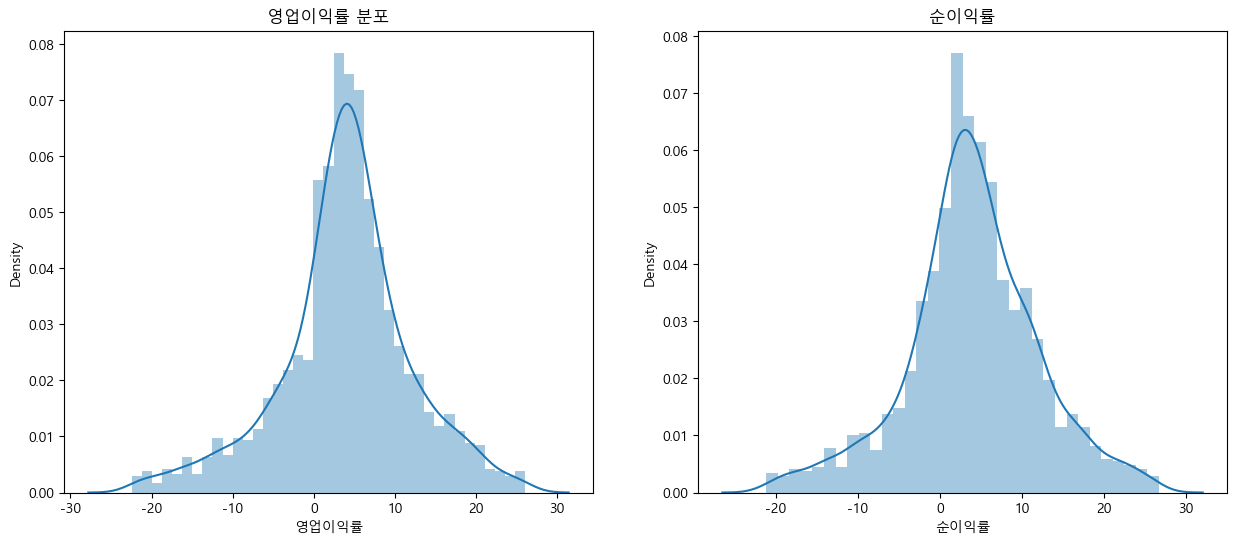

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# distplot
sns.distplot(df1_cleaned['영업이익률'], kde=True, ax=axes[0])
axes[0].set_title('영업이익률 분포')

# boxplot
sns.distplot(df1_cleaned['순이익률'], kde=True, ax=axes[1])
axes[1].set_title('순이익률')

plt.show()

### 1.2 수익성 데이터(극단치 제거) 클러스터링

In [12]:
# 데이터 표준화
scaler = StandardScaler()
scaled_data_cleaned1 = scaler.fit_transform(df1_cleaned)

# K-Means 클러스터링 수행
kmeans_cleaned1 = KMeans(n_clusters=2, random_state=42)
df1_cleaned['Cluster'] = kmeans_cleaned1.fit_predict(scaled_data_cleaned1)

# 클러스터링 결과
df1_cleaned['Cluster'].value_counts()

C:\Users\myhyu\AppData\Local\Temp\ipykernel_24832\2284671840.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_cleaned['Cluster'] = kmeans_cleaned1.fit_predict(scaled_data_cleaned1)


Cluster
1    969
0    937
Name: count, dtype: int64

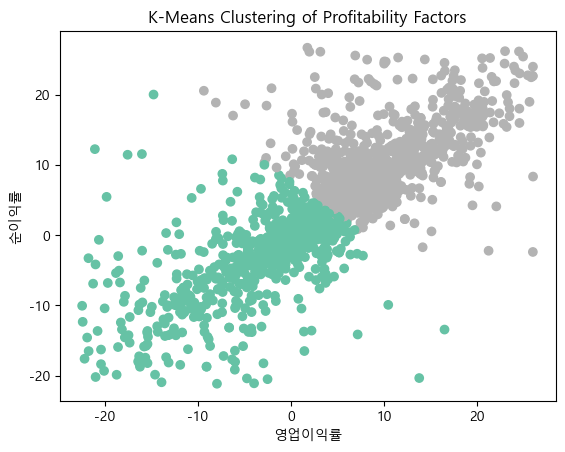

In [13]:
plt.scatter(df1_cleaned['영업이익률'], df1_cleaned['순이익률'], c=df1_cleaned['Cluster'], cmap='Set2' )
plt.xlabel('영업이익률')
plt.ylabel('순이익률')
plt.title('K-Means Clustering of Profitability Factors')
plt.show()

### 1.3 클러스터링 경계로 수익성 데이터 데이터 분류

In [14]:
# 원본 데이터 표준화
scaled_data_original1 = scaler.transform(df1)

# 클러스터링을 원본 데이터에 적용
def assign_cluster(row, kmeans_model, scaler):
    scaled_row = scaler.transform([row])
    return kmeans_model.predict(scaled_row)[0]

# 원본 데이터에 군집 분류 적용
df1['Cluster'] = df1.apply(lambda row: assign_cluster(row, kmeans_cleaned1, scaler), axis=1)

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

In [15]:
df1.Cluster.value_counts()

Cluster
0    1267
1    1095
Name: count, dtype: int64

In [16]:
df1['수익성'] = np.where(df1['Cluster'] == 0, 'p', 'P')

print(df1)

      영업이익률   순이익률  Cluster 수익성
0      7.95   2.16        1   P
1      8.08   3.56        1   P
2      9.55   9.71        1   P
3      1.67   1.20        0   p
4     11.75   9.61        1   P
...     ...    ...      ...  ..
2357  -0.59   0.41        0   p
2358   9.20   9.77        1   P
2359   8.20   3.72        1   P
2360   3.17   5.63        1   P
2361  11.93  12.50        1   P

[2362 rows x 4 columns]


C:\Users\myhyu\AppData\Local\Temp\ipykernel_24832\39036198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['수익성'] = np.where(df1['Cluster'] == 0, 'p', 'P')


In [17]:
df1[['Cluster','수익성']].value_counts()

Cluster  수익성
0        p      1267
1        P      1095
Name: count, dtype: int64

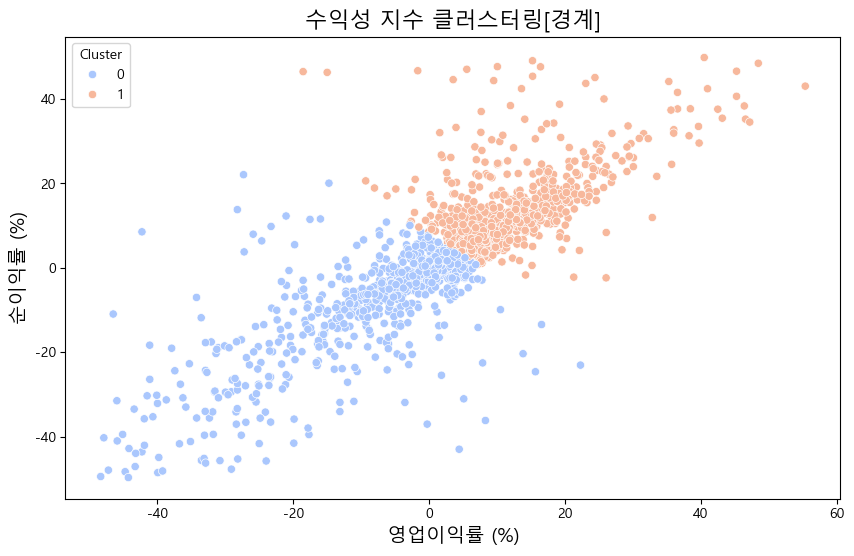

In [18]:
# 시각화
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x='영업이익률', 
    y='순이익률', 
    hue='Cluster', 
    palette='coolwarm', 
    data=df1.query('영업이익률>-50& -50<순이익률<50')
)

# 그래프 제목과 축 레이블 설정
scatter_plot.set_title('수익성 지수 클러스터링[경계]', fontsize=16)
scatter_plot.set_xlabel('영업이익률 (%)', fontsize=14)
scatter_plot.set_ylabel('순이익률 (%)', fontsize=14)

plt.show()

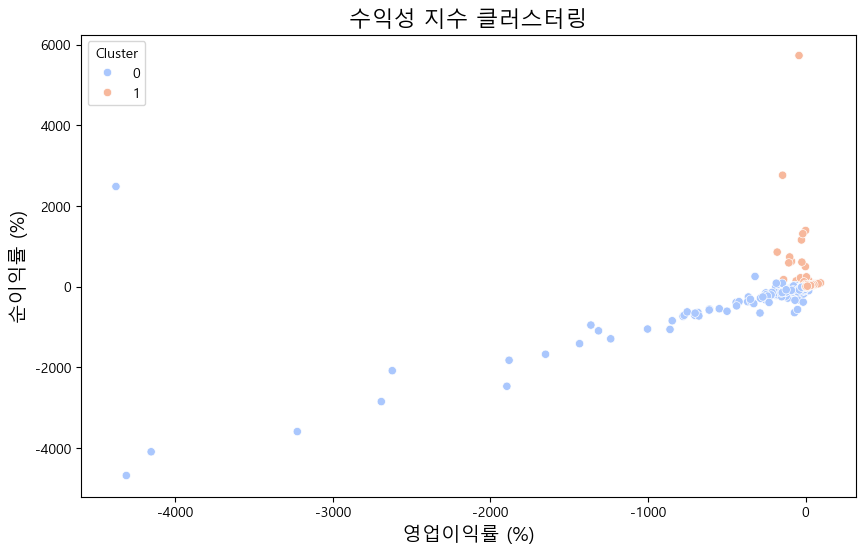

In [19]:
# 시각화
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x='영업이익률', 
    y='순이익률', 
    hue='Cluster', 
    palette='coolwarm', 
    data=df1
)

# 그래프 제목과 축 레이블 설정
scatter_plot.set_title('수익성 지수 클러스터링', fontsize=16)
scatter_plot.set_xlabel('영업이익률 (%)', fontsize=14)
scatter_plot.set_ylabel('순이익률 (%)', fontsize=14)

plt.show()

In [20]:
df1.drop(columns=['Cluster'], inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   영업이익률   2362 non-null   float64
 1   순이익률    2362 non-null   float64
 2   수익성     2362 non-null   object 
dtypes: float64(2), object(1)
memory usage: 55.5+ KB


C:\Users\myhyu\AppData\Local\Temp\ipykernel_24832\1170605018.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns=['Cluster'], inplace=True)


---
# 2. 가치
- PER, PBR

In [21]:
df2 = df[['PER','PBR']]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PER     2362 non-null   float64
 1   PBR     2362 non-null   float64
dtypes: float64(2)
memory usage: 37.0 KB


In [22]:
df2.corr()

,PER,PBR
PER,1.000000,0.001605
PBR,0.001605,1.000000


### 2.1 가치 데이터 극단치 제거 
df2_cleaned

In [23]:
# 극단치 제거된 데이터
df2_cleaned = remove_outliers_iqr(df2)

df2_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1858 entries, 0 to 2361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PER     1858 non-null   float64
 1   PBR     1858 non-null   float64
dtypes: float64(2)
memory usage: 43.5 KB


C:\Users\myhyu\AppData\Local\Temp\ipykernel_24832\95940309.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df2_cleaned['PER'], kde=True, ax=axes[0])
C:\Users\myhyu\AppData\Local\Temp\ipykernel_24832\95940309.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df2_cleaned['PBR'], kde=True, ax

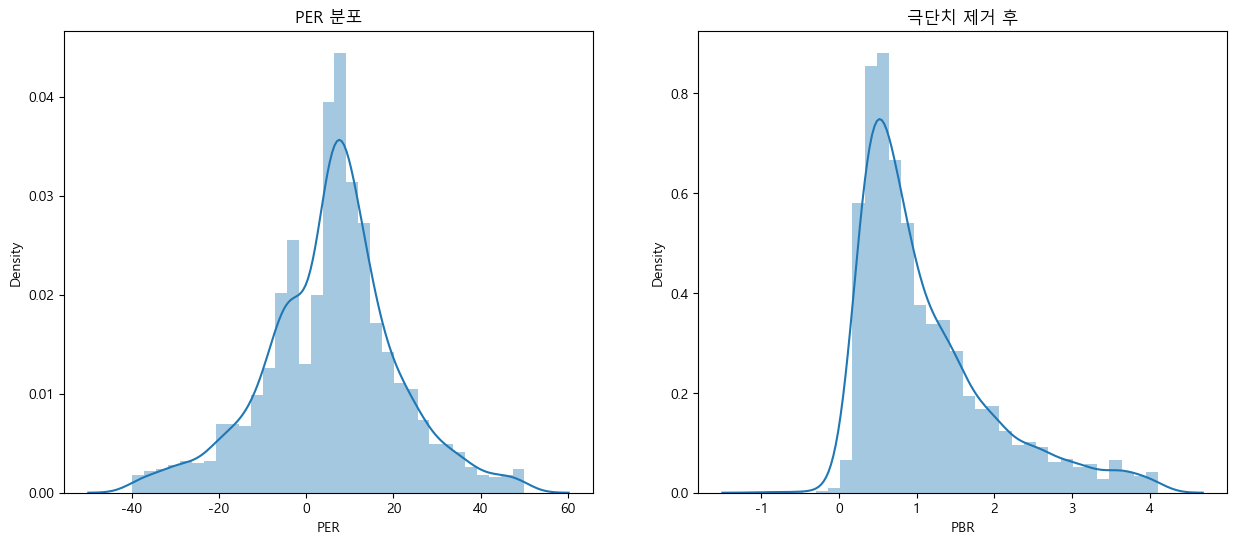

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# distplot
sns.distplot(df2_cleaned['PER'], kde=True, ax=axes[0])
axes[0].set_title('PER 분포')

# boxplot
sns.distplot(df2_cleaned['PBR'], kde=True, ax=axes[1])
axes[1].set_title('PBR 분포')

plt.title('극단치 제거 후')
plt.show()

### 2.2 가치 데이터(극단치 제거) 클러스터링

In [25]:
# 데이터 표준화
scaler = StandardScaler()
scaled_data_cleaned2 = scaler.fit_transform(df2_cleaned)

# K-Means 클러스터링 수행
kmeans_cleaned2 = KMeans(n_clusters=2, random_state=42)
df2_cleaned['Cluster'] = kmeans_cleaned2.fit_predict(scaled_data_cleaned2)

# 클러스터링 결과
df2_cleaned['Cluster'].value_counts()

C:\Users\myhyu\AppData\Local\Temp\ipykernel_24832\746348728.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_cleaned['Cluster'] = kmeans_cleaned2.fit_predict(scaled_data_cleaned2)


Cluster
0    1461
1     397
Name: count, dtype: int64

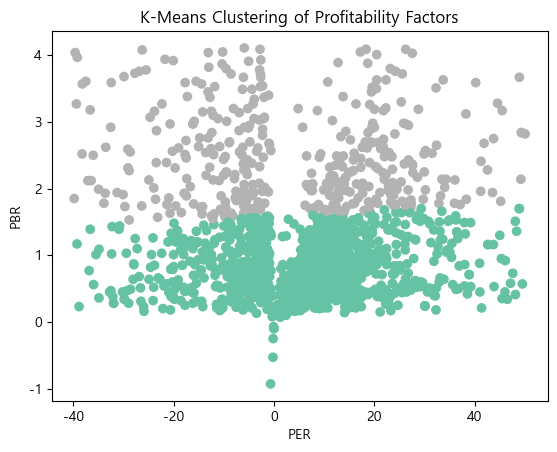

In [26]:
plt.scatter(df2_cleaned['PER'], df2_cleaned['PBR'], c=df2_cleaned['Cluster'], cmap='Set2' )
plt.xlabel('PER')
plt.ylabel('PBR')
plt.title('K-Means Clustering of Profitability Factors')
plt.show()

### 2.3 클러스터링 경계로 가치 데이터 분류

In [27]:
# 원본 데이터 표준화
scaled_data_original = scaler.transform(df2)

# 원본 데이터에 군집 분류 적용
df2['Cluster'] = df2.apply(lambda row: assign_cluster(row, kmeans_cleaned2, scaler), axis=1)

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

In [28]:
df2.Cluster.value_counts()

Cluster
0    1623
1     739
Name: count, dtype: int64

In [29]:
df2['가치'] = np.where(df2['Cluster'] == 0, 'v', 'V')

print(df2)

         PER   PBR  Cluster 가치
0      13.03  0.52        0  v
1      10.23  0.33        0  v
2       4.76  0.22        0  v
3      10.62  1.98        1  V
4       3.97  0.24        0  v
...      ...   ...      ... ..
2357  179.80  1.84        0  v
2358    5.56  0.62        0  v
2359   12.28  0.91        0  v
2360   13.10  1.19        0  v
2361    6.31  0.97        0  v

[2362 rows x 4 columns]


C:\Users\myhyu\AppData\Local\Temp\ipykernel_24832\372221761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['가치'] = np.where(df2['Cluster'] == 0, 'v', 'V')


In [30]:
df2[['Cluster','가치']].value_counts()

Cluster  가치
0        v     1623
1        V      739
Name: count, dtype: int64

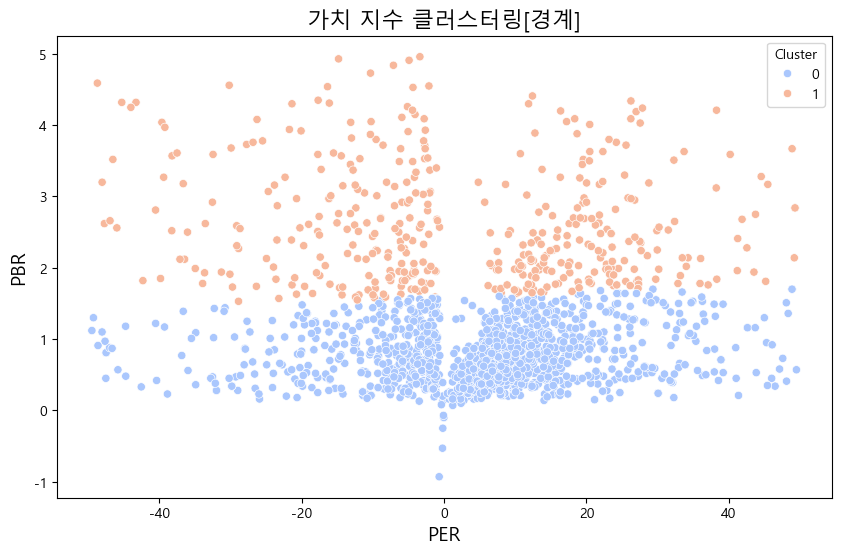

In [31]:
# 시각화
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x='PER', 
    y='PBR', 
    hue='Cluster', 
    palette='coolwarm', 
    data=df2.query('-50<PER<50& -1<PBR<5')
)

# 그래프 제목과 축 레이블 설정
scatter_plot.set_title('가치 지수 클러스터링[경계]', fontsize=16)
scatter_plot.set_xlabel('PER', fontsize=14)
scatter_plot.set_ylabel('PBR', fontsize=14)

plt.show()

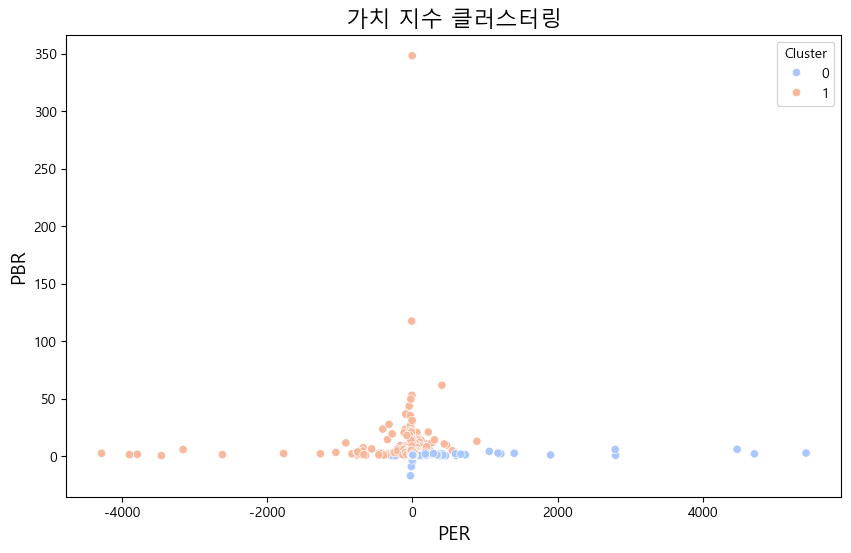

In [32]:
# 시각화
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x='PER', 
    y='PBR', 
    hue='Cluster', 
    palette='coolwarm', 
    data=df2
)

# 그래프 제목과 축 레이블 설정
scatter_plot.set_title('가치 지수 클러스터링', fontsize=16)
scatter_plot.set_xlabel('PER', fontsize=14)
scatter_plot.set_ylabel('PBR', fontsize=14)

plt.show()

In [33]:
df2.drop(columns=['Cluster'], inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PER     2362 non-null   float64
 1   PBR     2362 non-null   float64
 2   가치      2362 non-null   object 
dtypes: float64(2), object(1)
memory usage: 55.5+ KB


C:\Users\myhyu\AppData\Local\Temp\ipykernel_24832\1758402841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(columns=['Cluster'], inplace=True)


---
## 3. 퀄리티

In [34]:
df3 = df[['ROE','부채비율']]
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ROE     2362 non-null   float64
 1   부채비율    2362 non-null   float64
dtypes: float64(2)
memory usage: 37.0 KB


In [35]:
df3.corr()

,ROE,부채비율
ROE,1.000000,-0.089945
부채비율,-0.089945,1.000000


### 3.1 퀄리티 데이터 극단치 제거 
df3_cleaned

In [36]:
# 극단치 제거된 데이터
df3_cleaned = remove_outliers_iqr(df3)

df3_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1961 entries, 2 to 2361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ROE     1961 non-null   float64
 1   부채비율    1961 non-null   float64
dtypes: float64(2)
memory usage: 46.0 KB


C:\Users\myhyu\AppData\Local\Temp\ipykernel_24832\2364691332.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df3_cleaned['ROE'], kde=True, ax=axes[0])
C:\Users\myhyu\AppData\Local\Temp\ipykernel_24832\2364691332.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df3_cleaned['부채비율'], kde=Tru

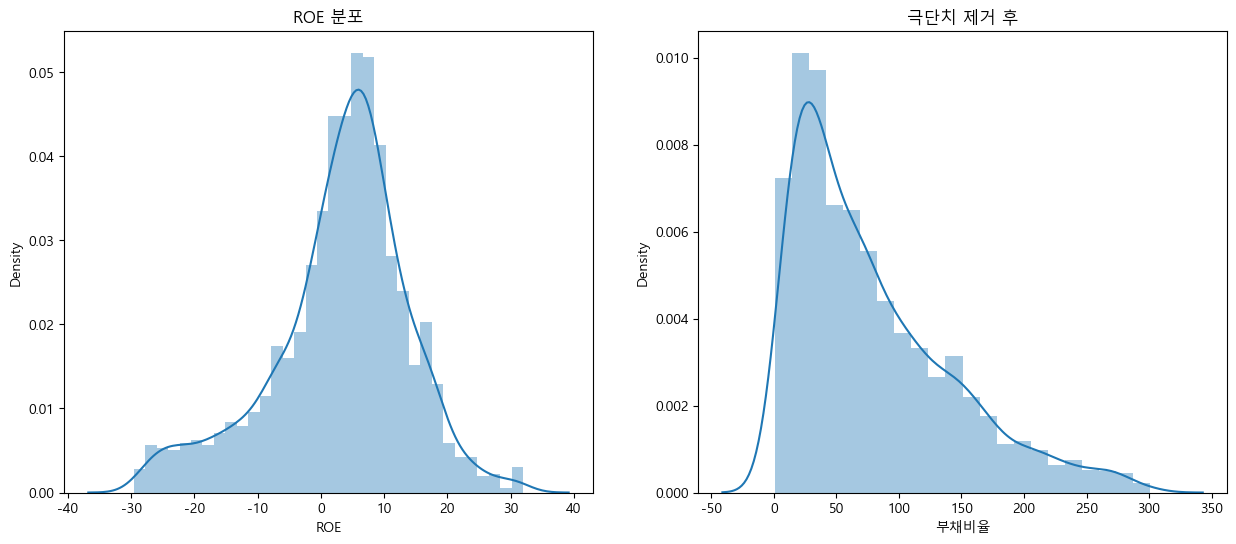

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# distplot
sns.distplot(df3_cleaned['ROE'], kde=True, ax=axes[0])
axes[0].set_title('ROE 분포')

# boxplot
sns.distplot(df3_cleaned['부채비율'], kde=True, ax=axes[1])
axes[1].set_title('부채비율 분포')

plt.title('극단치 제거 후')
plt.show()

### 3.2 퀄리티 지수 클러스터링

In [38]:
# 데이터 표준화
scaler = StandardScaler()
scaled_data_cleaned3 = scaler.fit_transform(df3_cleaned)

# K-Means 클러스터링 수행
kmeans_cleaned3 = KMeans(n_clusters=2, random_state=42)
df3_cleaned['Cluster'] = kmeans_cleaned3.fit_predict(scaled_data_cleaned3)

# 클러스터링 결과
df3_cleaned['Cluster'].value_counts()

C:\Users\myhyu\AppData\Local\Temp\ipykernel_24832\4254901446.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_cleaned['Cluster'] = kmeans_cleaned3.fit_predict(scaled_data_cleaned3)


Cluster
0    1389
1     572
Name: count, dtype: int64

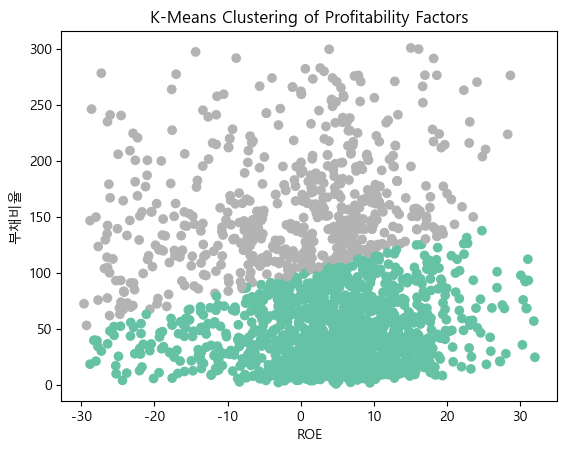

In [39]:
plt.scatter(df3_cleaned['ROE'], df3_cleaned['부채비율'], c=df3_cleaned['Cluster'], cmap='Set2' )
plt.xlabel('ROE')
plt.ylabel('부채비율')
plt.title('K-Means Clustering of Profitability Factors')
plt.show()

### 3.3 클러스터링 경계로 퀄리티 원본 데이터 분류

In [40]:
# 원본 데이터 표준화
scaled_data_original3 = scaler.transform(df3)

# 원본 데이터에 군집 분류 적용
df3['Cluster'] = df3.apply(lambda row: assign_cluster(row, kmeans_cleaned3, scaler), axis=1)

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\myhyu\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

C:\Users\myhyu\AppData\Local\Temp\ipykernel_24832\2650320931.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Cluster'] = df3.apply(lambda row: assign_cluster(row, kmeans_cleaned3, scaler), axis=1)


In [41]:
df3.Cluster.value_counts()

Cluster
0    1439
1     923
Name: count, dtype: int64

In [42]:
df3['퀄리티'] = np.where(df3['Cluster'] == 0, 'q', 'Q')

print(df3)

        ROE     부채비율  Cluster 퀄리티
0      4.26   305.26        1   Q
1      3.33   319.33        1   Q
2      4.64    14.85        0   q
3     19.69   214.53        1   Q
4      6.30  1275.09        1   Q
...     ...      ...      ...  ..
2357   1.06    17.30        0   q
2358  12.89    25.14        0   q
2359   7.91   112.21        0   q
2360  10.41   169.13        1   Q
2361  16.99    36.64        0   q

[2362 rows x 4 columns]


C:\Users\myhyu\AppData\Local\Temp\ipykernel_24832\3731119067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['퀄리티'] = np.where(df3['Cluster'] == 0, 'q', 'Q')


In [43]:
df3[['Cluster','퀄리티']].value_counts()

Cluster  퀄리티
0        q      1439
1        Q       923
Name: count, dtype: int64

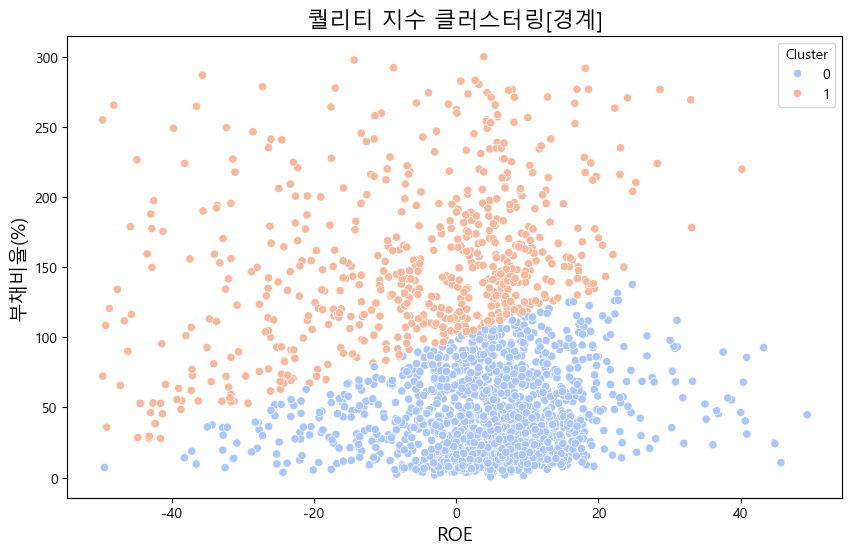

In [44]:
# 시각화
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x='ROE', 
    y='부채비율', 
    hue='Cluster', 
    palette='coolwarm', 
    data=df3.query('-50<ROE<50& -5<부채비율<300')
)

# 그래프 제목과 축 레이블 설정
scatter_plot.set_title('퀄리티 지수 클러스터링[경계]', fontsize=16)
scatter_plot.set_xlabel('ROE', fontsize=14)
scatter_plot.set_ylabel('부채비율(%)', fontsize=14)

plt.show()

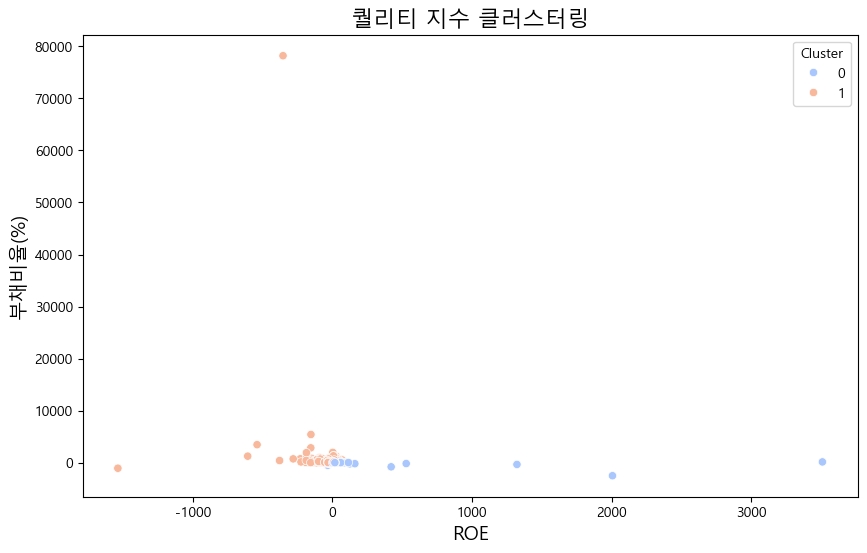

In [45]:
# 시각화
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x='ROE', 
    y='부채비율', 
    hue='Cluster', 
    palette='coolwarm', 
    data=df3
)

# 그래프 제목과 축 레이블 설정
scatter_plot.set_title('퀄리티 지수 클러스터링', fontsize=16)
scatter_plot.set_xlabel('ROE', fontsize=14)
scatter_plot.set_ylabel('부채비율(%)', fontsize=14)

plt.show()

In [46]:
df3.drop(columns=['Cluster'], inplace=True)
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ROE     2362 non-null   float64
 1   부채비율    2362 non-null   float64
 2   퀄리티     2362 non-null   object 
dtypes: float64(2), object(1)
memory usage: 55.5+ KB


C:\Users\myhyu\AppData\Local\Temp\ipykernel_24832\2822117819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.drop(columns=['Cluster'], inplace=True)


---
# 5. 데이터 합치기

In [47]:
df #원본 데이터

,기업코드,영업이익률,순이익률,매출액차,부채비율,PER,PBR,ROE,매출성장률,기업명
0,095570,7.95,2.16,2448.0,305.26,13.03,0.52,4.26,-0.970874,AJ네트웍스
1,006840,8.08,3.56,11934.0,319.33,10.23,0.33,3.33,3.235294,AK홀딩스
2,027410,9.55,9.71,1185.0,14.85,4.76,0.22,4.64,-3.970827,BGF
3,282330,1.67,1.20,19538.0,214.53,10.62,1.98,19.69,-4.234879,BGF리테일
4,138930,11.75,9.61,26505.0,1275.09,3.97,0.24,6.30,9.213400,BNK금융지주
...,...,...,...,...,...,...,...,...,...,...
2357,024060,-0.59,0.41,306.0,17.30,179.80,1.84,1.06,-4.968944,흥구석유
2358,010240,9.20,9.77,353.0,25.14,5.56,0.62,12.89,2.023121,흥국
2359,189980,8.20,3.72,225.0,112.21,12.28,0.91,7.91,15.979381,흥국에프엔비
2360,037440,3.17,5.63,563.0,169.13,13.10,1.19,10.41,-14.437690,희림


In [48]:
# 데이터프레임을 수직으로 결합
df_total = pd.concat([df[['기업코드','기업명']],df1, df2, df3], axis=1)
df_total['기업분류지표'] = df_total['수익성']+df_total['가치']+df_total['퀄리티']
df_total

,기업코드,기업명,영업이익률,순이익률,수익성,PER,PBR,가치,ROE,부채비율,퀄리티,기업분류지표
0,095570,AJ네트웍스,7.95,2.16,P,13.03,0.52,v,4.26,305.26,Q,PvQ
1,006840,AK홀딩스,8.08,3.56,P,10.23,0.33,v,3.33,319.33,Q,PvQ
2,027410,BGF,9.55,9.71,P,4.76,0.22,v,4.64,14.85,q,Pvq
3,282330,BGF리테일,1.67,1.20,p,10.62,1.98,V,19.69,214.53,Q,pVQ
4,138930,BNK금융지주,11.75,9.61,P,3.97,0.24,v,6.30,1275.09,Q,PvQ
...,...,...,...,...,...,...,...,...,...,...,...,...
2357,024060,흥구석유,-0.59,0.41,p,179.80,1.84,v,1.06,17.30,q,pvq
2358,010240,흥국,9.20,9.77,P,5.56,0.62,v,12.89,25.14,q,Pvq
2359,189980,흥국에프엔비,8.20,3.72,P,12.28,0.91,v,7.91,112.21,q,Pvq
2360,037440,희림,3.17,5.63,P,13.10,1.19,v,10.41,169.13,Q,PvQ


In [49]:
df_final = df_total[['기업코드','기업명','수익성','가치','퀄리티','기업분류지표']]
df_final

,기업코드,기업명,수익성,가치,퀄리티,기업분류지표
0,095570,AJ네트웍스,P,v,Q,PvQ
1,006840,AK홀딩스,P,v,Q,PvQ
2,027410,BGF,P,v,q,Pvq
3,282330,BGF리테일,p,V,Q,pVQ
4,138930,BNK금융지주,P,v,Q,PvQ
...,...,...,...,...,...,...
2357,024060,흥구석유,p,v,q,pvq
2358,010240,흥국,P,v,q,Pvq
2359,189980,흥국에프엔비,P,v,q,Pvq
2360,037440,희림,P,v,Q,PvQ


In [51]:
df_final.to_csv('기업분류지표_3가지ver.csv', encoding='cp949')